This script is used to perform a sensitivity analysis of the MERCURY model. More details can be found in the accompanying paper: 

# Library Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib, pylab as plt
from ast import literal_eval
import statsmodels.api as sm
from sklearn import preprocessing
import math

# Data import
Import the csv files and merge them together. 

'literal_eval' is used to read the 'site_dict' (which contains information for each site and the traders on that site) as lists instead of strings. It contains one item for each site. The site data is formatted like this:
[ site_number, [ producer, volume_A, volume_B, volume_C, volume_D, [[ closeness_centrality, betweenness_centrality ], [..., ...]]
- *site_number* is the number of the site

- *producer* holds whether the site is a production site, and if so of which product, i.e. "A, "B", "C", "D" or "N", if the site is not a production site.

- *volume_X* holds the amount of product of each type that is deposited on the site.

- *closeless_centrality* and *betweenness_centrality* hold the closeness centrality and betweenness centrality of a trader. These values are recorded for each trader on a site, and stored in a list.

The site_dict is not an actual Python dictionary yet, but a list. It is converted to a dict when needed. The dict is not displayed because it is too large.

The runs that did not complete their setup are dropped.

In [2]:
pd.set_option('display.max_columns', 100)

def literal_converter(val):
    return val if val == 'avg_degree stuck' else literal_eval(val)

df = pd.read_csv('batch1_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter})
df = df.append(pd.read_csv('batch2_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch2_remaining_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch3_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch4_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch5_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch6_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch7_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))

print(str(len(df)))

df_dropped = df[df.site_dict == 'avg_degree stuck']
df = df[df.site_dict != 'avg_degree stuck']

print("Number of runs stuck on average degree " + str(len(df_dropped)))

14850
Number of runs stuck on average degree 171


There are three variables in the raw data that could be represented as integers, but are not. Here, they are converted to integers to facilitate data analysis.

equal_traders_production_site:

- True → 1

- False → 0

traders_distibution:

- uniform → 0

- exponential → 1

network_structure:

- random → 0

- hypothesis → 1

In [3]:
df['equal_traders_production_site'] *= 1
df = df.replace({'traders_distribution': {'uniform': 0, 'exponential': 1}, 'network_structure': {'random': 0, 'hypothesis': 1}})

df.drop(['site_dict'], axis=1).sample(10)

,random_seed,ticks,equal_traders_production_site,traders_distribution,network_structure,proportion_inter_site_links,proportion_intra_site_links,proportion_mutual_neighbors,traders_production_site,one_production_site_dominance,maximum_degree,local_knowledge,maximum_demand,circle_link_counter,inter_link_counter,intra_link_counter,mutual_link_counter,connect_components_link_counter,average_degree,clustering_coefficient,average_path_length
2207,6,5000,0,1,1,0.0001,0.0010,2,0,0,5,0.5,1,100,50,1039,1073,7,4.538,0.574138,13.676125
1132,3,5000,0,1,1,0.0010,0.0001,2,0,10,5,0.1,50,100,500,861,790,8,4.518,0.372044,6.434725
1639,6,5000,1,1,1,0.0010,0.0001,2,10,0,5,1.0,10,100,500,860,793,5,4.516,0.370329,6.425275
1847,5,5000,0,1,1,0.0000,0.0010,2,0,50,5,1.0,10,100,0,1044,1110,16,4.540,0.609305,89.748924
736,5,5000,1,1,1,0.0030,0.0001,2,10,0,5,1.0,1,100,1499,499,156,3,4.514,0.068193,5.151223
3056,9,5000,0,0,1,0.0030,0.0010,2,0,50,5,1.0,50,100,1499,535,131,4,4.538,0.064794,5.107492
221,1,5000,1,1,1,0.0010,0.0001,2,1,0,5,0.5,50,100,500,851,800,8,4.518,0.378271,6.413227
2129,8,5000,0,0,1,0.0001,0.0010,2,0,10,5,1.0,10,100,50,1043,1058,10,4.522,0.577630,14.186515
1693,6,5000,1,1,1,0.0001,0.0001,2,1,0,5,1.0,1,100,50,900,1202,21,4.546,0.661832,15.979442
1838,5,5000,0,1,1,0.0001,0.0010,2,0,50,5,0.1,10,100,50,1064,1045,12,4.542,0.555374,13.074124


# Calculate Ddiff

The Ddiff is the summary statistic we use to analyse the MERCURY model. It is meant to represent the difference between the distribution range of different ware types between the archaeological data and the simulated data. It is defined as follows:

\begin{align*}
Ddiff = \frac{\sqrt{{(R1a - R1s})^2{(R2a - R2s})^2}}{1000}
\end{align*}

We divide by a constant to get a range of values that's easier to interpret.

R1a and R1s are the ranges as defined by Brughmans and Poblome (2016), from the archaeological data and the simulated data respectively. It can be described as the *distribution width of the most widely distributed ware minus the distribution width of the least widely distributed ware*.

R2a and R2s are also ranges from the archaeological and simulated data, but it is calculated differently. It is defined as follows: *distribution width of the most widely distributed ware minus the distribution width of the second most widely distributed ware*. 

<img src="files/ranges.png">

The following sections cover all calculations that need to be made in order to calculate the Ddiff.


### Calculate distribution widths for all runs

The distribution width is defined as the number of sites a ware is located on. It only takes into account whether the ware is located on a site, not the amount of that ware. Since there are 100 sites in the simulation, distribution width can range from 0 to 100. 

Here, a function is used to create a list of the distribution width of each tableware type, which is then sorted from highest to lowest. This function is used to add four new columns to the dataframe, containing the distrubtion widthsof the most common ware to the least common ware. Ware type is not noted here, as it is not relevant for our analysis.

In [4]:
def calc_widths(row):
    widths = [0,0,0,0]
    site_dict = dict(row['site_dict'])
    for site_num, site_stats in site_dict.items():
        if site_stats[1] > 0:
            widths[0] += 1
        if site_stats[2] > 0:
            widths[1] += 1
        if site_stats[3] > 0:
            widths[2] += 1
        if site_stats[4] > 0:
            widths[3] += 1
    widths.sort()
    widths.reverse()
    return widths [0], widths[1], widths[2], widths[3]

df['volume_1'], df['volume_2'], df['volume_3'], df['volume_4'] = zip(*df.apply(calc_widths, axis=1))

df.drop(['site_dict'], axis=1).sample(10)

,random_seed,ticks,equal_traders_production_site,traders_distribution,network_structure,proportion_inter_site_links,proportion_intra_site_links,proportion_mutual_neighbors,traders_production_site,one_production_site_dominance,maximum_degree,local_knowledge,maximum_demand,circle_link_counter,inter_link_counter,intra_link_counter,mutual_link_counter,connect_components_link_counter,average_degree,clustering_coefficient,average_path_length,volume_1,volume_2,volume_3,volume_4
641,7,5000,1,0,1,0.0000,0.0010,2,1,0,5,0.5,10,100,0,1055,1101,12,4.536,0.608003,93.412730,5,4,3,3
1825,7,5000,1,1,1,0.0030,0.0030,2,30,0,5,0.1,50,100,1499,570,115,4,4.576,0.059606,5.088056,100,99,99,99
65,1,5000,0,0,1,0.0001,0.0030,2,0,10,5,1.0,10,100,50,1313,790,19,4.544,0.469097,13.726271,6,5,5,2
1038,4,5000,1,1,1,0.0000,0.0030,2,1,0,5,0.5,50,100,0,1406,749,5,4.520,0.448639,80.053300,5,5,5,3
2741,10,5000,0,0,1,0.0001,0.0030,2,0,30,5,1.0,50,100,50,1340,787,10,4.574,0.467661,13.839851,10,9,6,5
1035,4,5000,0,0,1,0.0010,0.0010,2,0,0,5,0.5,10,100,500,960,709,7,4.552,0.339282,6.227568,47,44,25,19
4118,10,5000,0,1,1,0.0001,0.0010,2,0,30,5,0.5,1,100,50,1058,1057,8,4.546,0.540075,13.231099,4,3,2,2
1263,5,5000,0,0,1,0.0001,0.0030,2,0,50,5,0.1,10,100,50,1379,763,5,4.594,0.465347,13.404862,8,5,3,3
2084,5,5000,0,1,1,0.0000,0.0001,2,0,30,5,0.1,1,100,0,911,1241,30,4.564,0.686768,93.565346,3,2,2,2
9,1,5000,1,1,1,0.0000,0.0010,2,1,0,5,0.1,1,100,0,1054,1097,14,4.530,0.579278,80.630360,2,2,2,2


### Calculate R1s and R2s for all runs

In [5]:
df["R1s"] = df.apply(lambda x: x["volume_1"] - x["volume_4"], axis = 1)
df["R2s"] = df.apply(lambda x: x["volume_1"] - x["volume_2"], axis = 1)

df.drop(['site_dict'], axis=1).sample(10)

,random_seed,ticks,equal_traders_production_site,traders_distribution,network_structure,proportion_inter_site_links,proportion_intra_site_links,proportion_mutual_neighbors,traders_production_site,one_production_site_dominance,maximum_degree,local_knowledge,maximum_demand,circle_link_counter,inter_link_counter,intra_link_counter,mutual_link_counter,connect_components_link_counter,average_degree,clustering_coefficient,average_path_length,volume_1,volume_2,volume_3,volume_4,R1s,R2s
3056,8,5000,0,1,1,0.0001,0.001,2,0,10,5,1.0,10,100,50,1030,1075,16,4.542,0.565704,13.962539,4,3,3,2,2,1
3048,10,5000,1,1,1,0.0010,0.001,2,30,0,5,0.1,50,100,500,952,715,10,4.554,0.334125,6.226178,81,78,75,61,20,3
2712,9,5000,1,1,1,0.0001,0.003,2,1,0,5,1.0,50,100,50,1359,763,2,4.548,0.447923,11.859402,7,6,6,5,2,1
408,3,5000,1,0,1,0.0010,0.003,2,10,0,5,1.0,50,100,500,1199,470,7,4.552,0.284447,6.161365,50,45,43,31,19,5
3810,9,5000,0,1,1,0.0001,0.001,2,0,30,5,0.5,50,100,50,1029,1072,10,4.522,0.555533,14.355479,10,8,5,5,5,2
320,2,5000,1,1,1,0.0030,0.003,2,10,0,5,1.0,50,100,1499,578,96,4,4.554,0.046824,5.057673,95,94,94,93,2,1
598,9,5000,0,0,1,0.0000,0.003,2,0,30,5,1.0,10,100,0,1358,821,20,4.598,0.474467,86.111786,3,3,2,2,1,0
899,3,5000,0,0,1,0.0010,0.001,2,0,50,5,1.0,50,100,500,975,692,11,4.556,0.322450,6.272664,90,26,15,14,76,64
147,1,5000,1,1,1,0.0001,0.003,2,1,0,5,0.1,50,100,50,1330,780,8,4.536,0.436691,12.855463,6,5,5,4,2,1
1736,6,5000,1,1,1,0.0000,0.003,2,10,0,5,1.0,1,100,0,1349,807,10,4.532,0.453013,79.591620,3,3,3,3,0,0


### Calculate R1a & R2a

Tableware data taken from supplement 1 of  Brughmans and Poblome (2016), which is in turn a sample of the ICRATES dataset.

Period definitions:

P1 = 25-1 BC

P2 = 1-25 AD

P3 = 25-50 AD

P4 = 50-75 AD

P5 = 75-100 AD

P6 = 100-125 AD

P7 = 125-150 AD

In [6]:
#Define all period width tables, sorted from highest to lowest (from ICRATES data)
P1 = [91.8, 22.0, 17.6, 8.2]
P2 = [85.8, 30.9, 18.5, 15.4]
P3 = [72.0, 29.6, 26.4, 24.0]
P4 = [64.0, 37.3, 35.3, 22.0]
P5 = [60.0, 41.5, 40.7, 20.0]
P6 = [45.9, 44.3, 42.6, 28.7]
P7 = [49.1, 34.3, 33.3, 31.5]

chosen_period = P1

#Calculate R1a and R2a
R1a = max(chosen_period) - min(chosen_period)
print('R1a = ' + str(R1a))

R2a = max(chosen_period) - chosen_period[1]
print('R2a = ' + str(R2a))

R1a = 83.6
R2a = 69.8


### Ddiff calculation for each run

In [7]:
df["Ddiff"] = df.apply(lambda x: math.sqrt((R1a - x["R1s"])**2 * ((R2a - x["R2s"])**2))/1000 , axis = 1)
df.drop(['site_dict'], axis=1).sample(10)

,random_seed,ticks,equal_traders_production_site,traders_distribution,network_structure,proportion_inter_site_links,proportion_intra_site_links,proportion_mutual_neighbors,traders_production_site,one_production_site_dominance,maximum_degree,local_knowledge,maximum_demand,circle_link_counter,inter_link_counter,intra_link_counter,mutual_link_counter,connect_components_link_counter,average_degree,clustering_coefficient,average_path_length,volume_1,volume_2,volume_3,volume_4,R1s,R2s,Ddiff
844,6,5000,1,1,1,0.001,0.0030,2,10,0,5,0.5,10,100,500,1217,451,6,4.548,0.238991,5.970146,49,44,29,14,35,5,3.14928
1016,3,5000,1,1,1,0.003,0.0010,2,10,0,5,0.5,50,100,1499,533,122,1,4.510,0.054456,5.125053,89,88,86,85,4,1,5.47648
652,2,5000,1,1,1,0.003,0.0001,2,30,0,5,0.5,50,100,1499,493,159,8,4.518,0.068537,5.136054,99,99,97,95,4,0,5.55608
1095,4,5000,1,1,1,0.000,0.0030,2,10,0,5,0.5,1,100,0,1363,792,10,4.530,0.460865,76.498390,3,3,3,3,0,0,5.83528
955,4,5000,1,1,1,0.000,0.0010,2,10,0,5,0.5,10,100,0,1061,1091,9,4.522,0.580729,89.237880,5,5,5,4,1,0,5.76548
924,3,5000,1,1,1,0.001,0.0030,2,10,0,5,1.0,50,100,500,1194,478,4,4.552,0.250563,6.063324,45,41,39,27,18,4,4.31648
2275,7,5000,1,1,1,0.003,0.0030,2,10,0,5,0.5,50,100,1499,569,95,3,4.532,0.044808,5.085606,99,92,91,88,11,7,4.55928
903,3,5000,1,1,1,0.001,0.0010,2,10,0,5,0.5,50,100,500,945,718,7,4.540,0.332066,6.266582,54,48,39,30,24,6,3.80248
747,7,5000,1,0,1,0.001,0.0001,2,1,0,5,1.0,50,100,500,860,792,7,4.518,0.378991,6.404661,23,19,16,13,10,4,4.84288
1731,7,5000,1,1,1,0.001,0.0030,2,30,0,5,1.0,1,100,500,1197,494,5,4.592,0.257690,5.948496,24,21,20,18,6,3,5.18368


# Regression analysis

### Regression of the full model
Multiple regression of Ddiff and all independent variables as well as the random_seed. All of these variables combined explain 52% of the Ddiff.

The variables were plotted on a log scale to check for linearity.

In [8]:
X = df[['random_seed', 
        'equal_traders_production_site',
        'traders_distribution',
        'network_structure',
        'proportion_inter_site_links',
        'proportion_intra_site_links',
        'traders_production_site',
        'one_production_site_dominance',
        'local_knowledge',
        'maximum_demand']]
X = sm.add_constant(X)
mreg = sm.OLS(df['Ddiff'], X)
results = mreg.fit()
print(results.summary())

H:\WindowsSoftware\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                  Ddiff   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     1490.
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:48:24   Log-Likelihood:                -24181.
No. Observations:               14679   AIC:                         4.838e+04
Df Residuals:                   14668   BIC:                         4.847e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Regression of 'proportion_inter_site_links' and 'one_production_site_dominance'
The bulk of predictive power, 46%, of the model are from 'proportion_inter_site_links' and 'one_production_site_dominance'.

In [9]:
X = df[['proportion_inter_site_links',
        'one_production_site_dominance' ]]
X = sm.add_constant(X)
mreg = sm.OLS(df['Ddiff'], X)
results = mreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ddiff   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     6201.
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:48:24   Log-Likelihood:                -24832.
No. Observations:               14679   AIC:                         4.967e+04
Df Residuals:                   14676   BIC:                         4.969e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Equalise the coefficient
The values of coefficient between 'proportion_inter_site_links' and 'one_production_site_dominance' are very different because the former ranges from 0.0001 to 0.003 while the latter ranges from 0 to 50. If we multiply the former by 1000 we'll be getting the same kind of values. This does not change the result, but it makes the coefficient eaier to compare.

In [10]:
df['prop_inter_site_links2'] = df['proportion_inter_site_links']*10000
X = df[['prop_inter_site_links2','one_production_site_dominance' ]]
X = sm.add_constant(X)
mreg = sm.OLS(df['Ddiff'], X)
results = mreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ddiff   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     6201.
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:48:24   Log-Likelihood:                -24832.
No. Observations:               14679   AIC:                         4.967e+04
Df Residuals:                   14676   BIC:                         4.969e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Regression of the remaining variables
The remaining variables explain only 10% of the Ddiff.

In [11]:
X = df[['random_seed', 
        'equal_traders_production_site',
        'traders_distribution',
        'network_structure',
        'proportion_intra_site_links',
        'traders_production_site',
        'local_knowledge',
        'maximum_demand' ]]
X = sm.add_constant(X)
mreg = sm.OLS(df['Ddiff'], X)
results = mreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ddiff   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     430.3
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:48:24   Log-Likelihood:                -27780.
No. Observations:               14679   AIC:                         5.558e+04
Df Residuals:                   14670   BIC:                         5.565e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Regression of 'random_seed' alone
If the random seed is significant, the variance of the model is too high to do regression analysis with this sample size. This is not the case with our model.

In [12]:
X = df['random_seed']
X = sm.add_constant(X)
reg = sm.OLS(df['Ddiff'], X)
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ddiff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9184
Date:                Tue, 04 Feb 2020   Prob (F-statistic):              0.338
Time:                        20:48:24   Log-Likelihood:                -29327.
No. Observations:               14679   AIC:                         5.866e+04
Df Residuals:                   14677   BIC:                         5.867e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.4186      0.032    138.805      

# Data visualisation

### Line plot of all independent variables

All independent variables that were varied throughout the runs are plotted against the mean Dddiff of all runs for each value of the independent variable. The values of the indepdenent variable are normalised.

This graph also shows that 'proportion_inter_site_links' and 'one_production_site_dominance' are important variables.

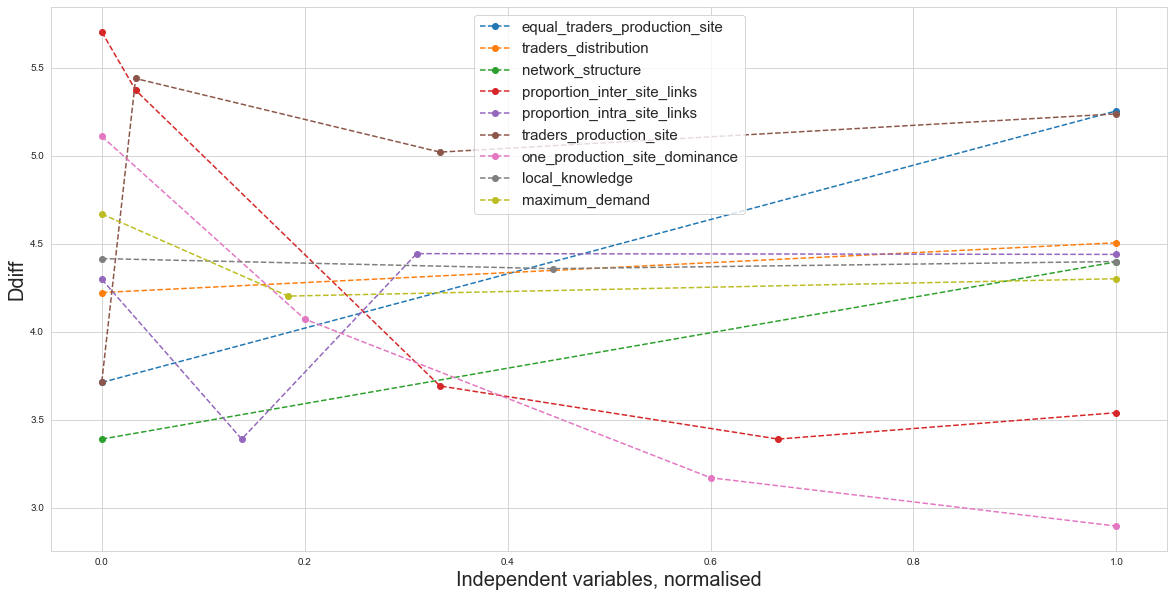

In [13]:
independent_variables = ['equal_traders_production_site',
                        'traders_distribution',
                        'network_structure',
                        'proportion_inter_site_links',
                        'proportion_intra_site_links',
                        'traders_production_site',
                        'one_production_site_dominance',
                        'local_knowledge',
                        'maximum_demand']

fig = plt.figure(figsize = (20, 10))
sns.set_style('whitegrid')

scaler=preprocessing.MinMaxScaler(feature_range=(0,1))

for i in independent_variables:
    df_temp = df.groupby(['{}'.format(i)]).mean().reset_index()
    df_temp["{}".format(i)]=scaler.fit_transform(df_temp[["{}".format(i)]])
    
    plt.plot(i, 'Ddiff', data=df_temp, linestyle='--', marker='o', label='{}'.format(i))
    
plt.xlabel('Independent variables, normalised', fontsize=20)
plt.ylabel('Ddiff', fontsize=20)
plt.legend(loc='best', fontsize=15)

### Violin plots of R1s

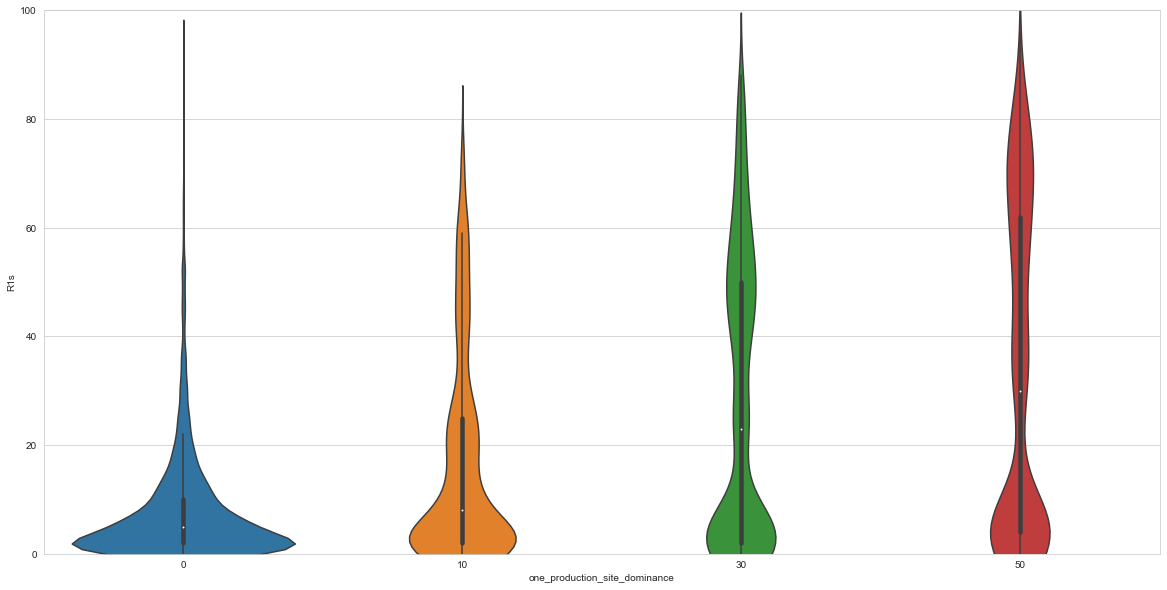

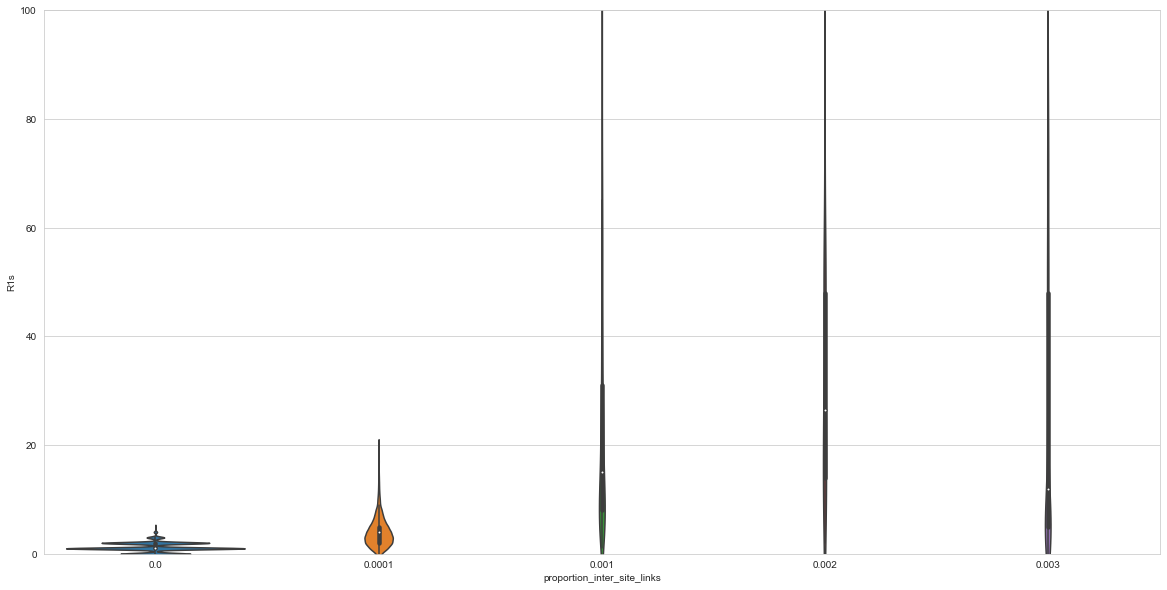

In [14]:
for i in ['one_production_site_dominance', 'proportion_inter_site_links']:
    fig, axes = plt.subplots(figsize = (20, 10))
    axes.set_ylim([0,100])
    ax = sns.violinplot(x=i, y = 'R1s', data=df)
    
    

### Violin plots of R2s

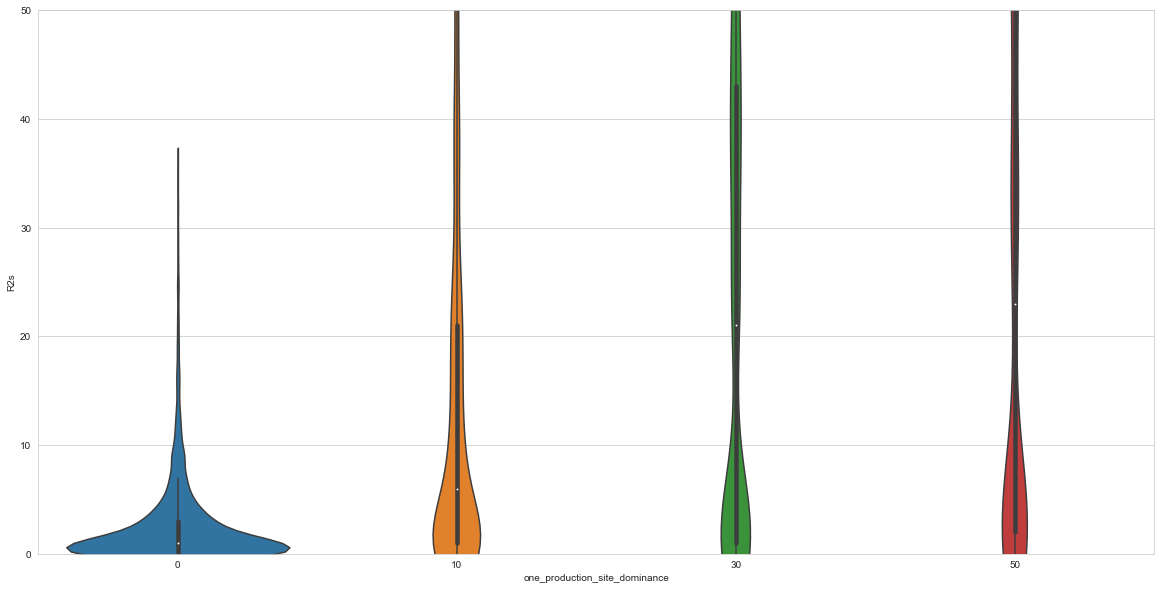

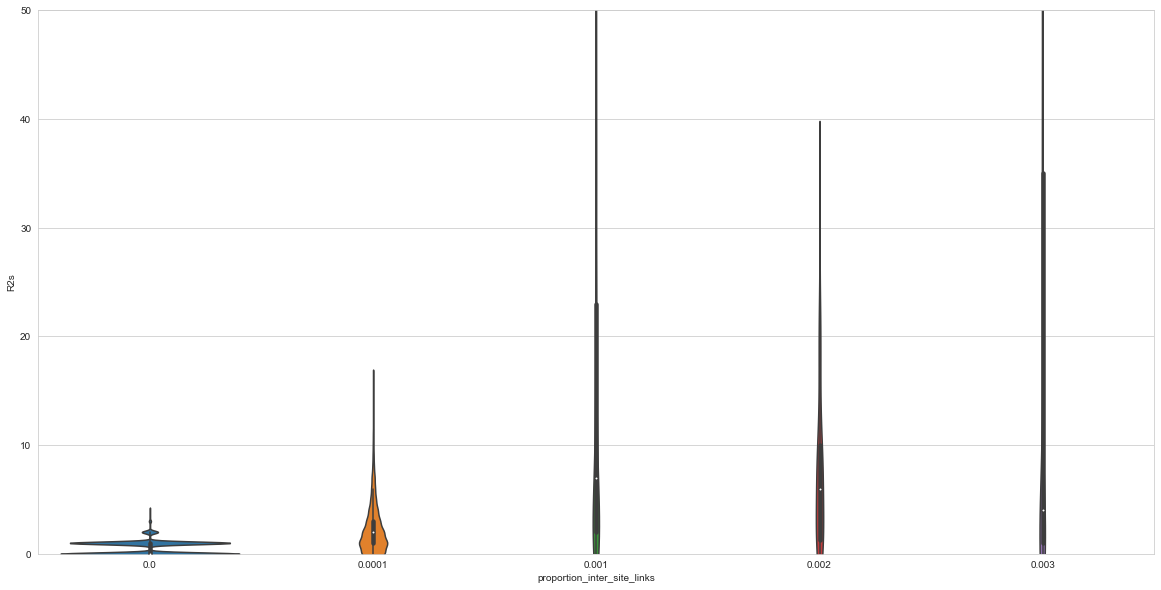

In [15]:
for i in ['one_production_site_dominance', 'proportion_inter_site_links']:
    fig, axes = plt.subplots(figsize = (20, 10))
    axes.set_ylim([0,50])
    ax = sns.violinplot(x=i, y = 'R2s', data=df)

### Violin plots of ranges and 'proportion_inter_site_links' split by values
The violin plots of the ranges against 'proportion_inter_site_links' are quite unreadable because of the large range of data. Here, they are split by value of 'proportion_inter_site_links' to make them more readable.

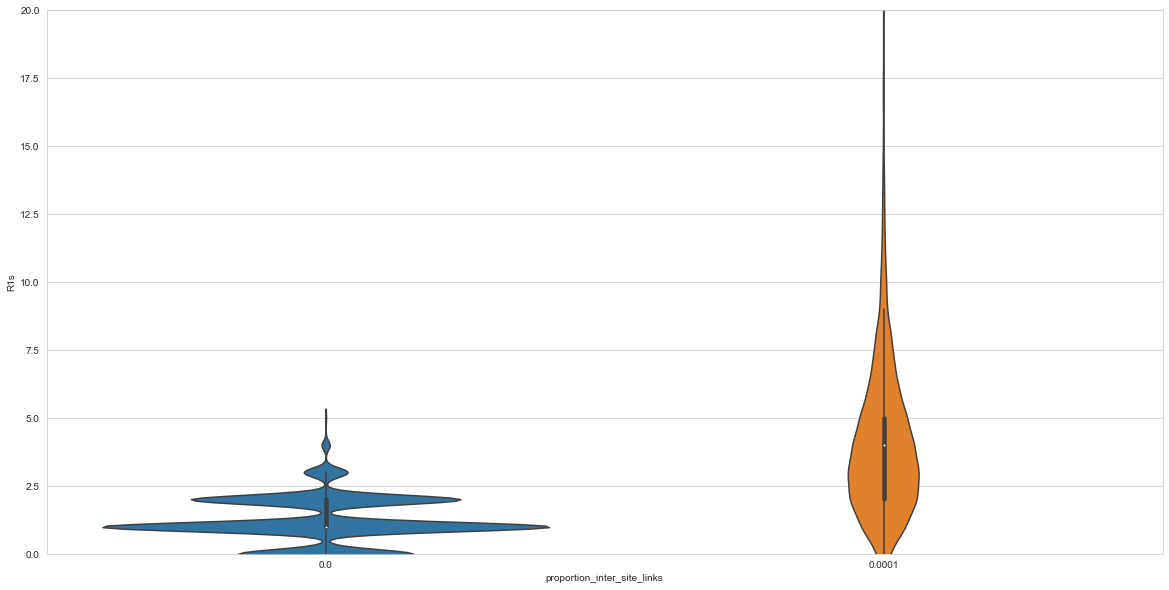

In [16]:
fig, axes = plt.subplots(figsize = (20, 10))
axes.set_ylim([0,20])
ax = sns.violinplot(x='proportion_inter_site_links', y = 'R1s', data=df.loc[df['proportion_inter_site_links'] <= 0.0001])

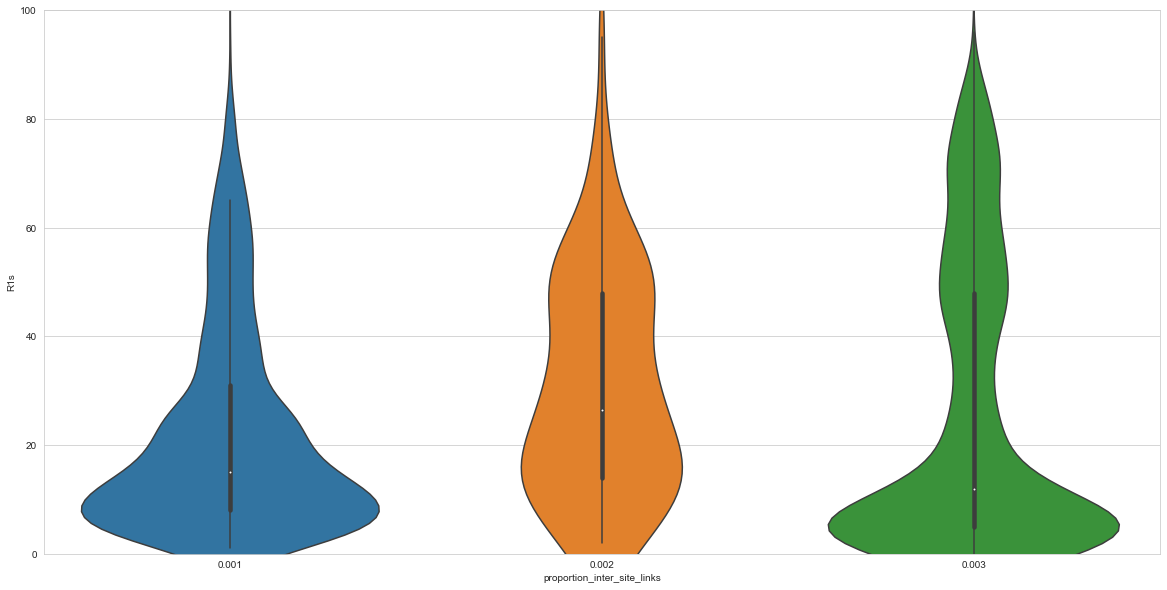

In [17]:
fig, axes = plt.subplots(figsize = (20, 10))
axes.set_ylim([0,100])
ax = sns.violinplot(x='proportion_inter_site_links', y = 'R1s', data=df.loc[df['proportion_inter_site_links'] > 0.0001])

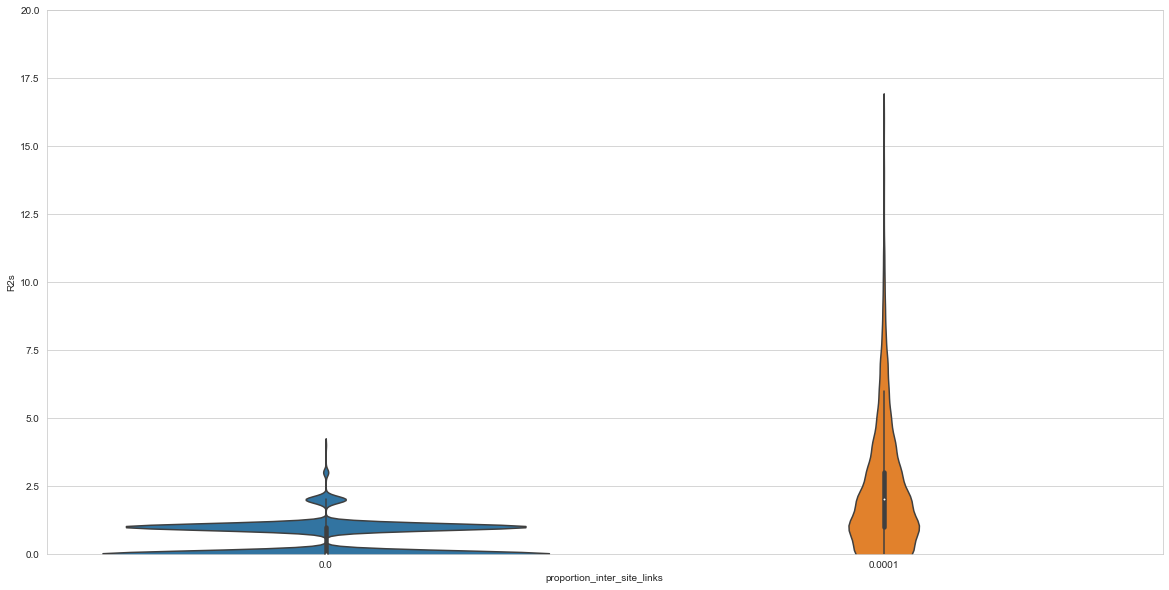

In [18]:
fig, axes = plt.subplots(figsize = (20, 10))
axes.set_ylim([0,20])
ax = sns.violinplot(x='proportion_inter_site_links', y = 'R2s', data=df.loc[df['proportion_inter_site_links'] <= 0.0001])

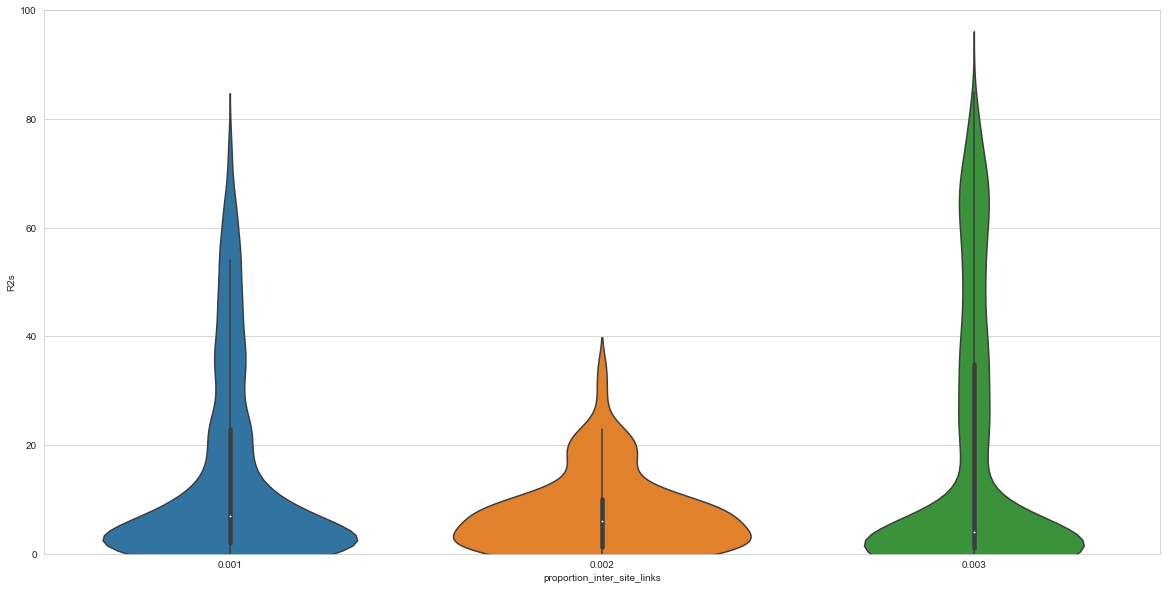

In [19]:
fig, axes = plt.subplots(figsize = (20, 10))
axes.set_ylim([0,100])
ax = sns.violinplot(x='proportion_inter_site_links', y = 'R2s', data=df.loc[df['proportion_inter_site_links'] > 0.0001])

### Violin plots of max closeness vs absence/presence of most widely distributed product

The closeness centrality is a way to quantify how central a node is in the network. It is defined as the reciprocal of the sum of the shortest paths between a node and all other nodes in the network. In the MERCURY model, a trader is a node. 

Here, the maximum closeness centrality among traders on a site is plotted against whether the most widely distributed ware is found on this site.

Text(0, 0.5, 'max_closeness per site')

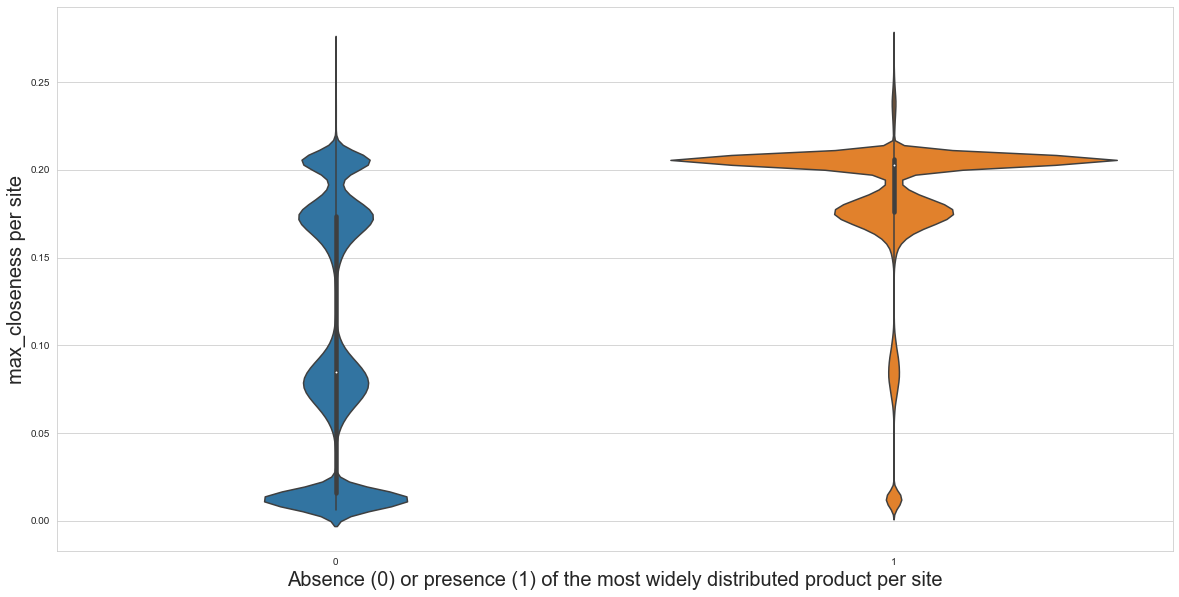

In [20]:
data_X = []

max_closeness_Y = []
max_betweenness_Y = []

for row, index in df.iterrows():
    
    widths = {'A': 0,
              'B': 0,
              'C': 0,
              'D': 0
             }
    
    site_dict = dict(index['site_dict'])
    
    for site_num, site_data in site_dict.items():
        if site_data[1] > 0:
            widths['A'] += 1
        if site_data[2] > 0:
            widths['B'] += 1
        if site_data[3] > 0:
            widths['C'] += 1
        if site_data[4] > 0:
            widths['D'] += 1
            
    ware_1 = max(widths, key=widths.get)
    
    for site_num, site_data in site_dict.items():
        closeness_list = []
        betweenness_list = []
        
        for i in site_data[5]:
            closeness_list.append(i[0])
            betweenness_list.append(i[1])
        
        if ware_1 == 'A' and site_data[1] > 0:
            data_X.append(1)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))
        elif ware_1 == 'B' and site_data[2] > 0:
            data_X.append(1)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))
        elif ware_1 == 'C' and site_data[3] > 0:
            data_X.append(1)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))
        elif ware_1 == 'D' and site_data[4] > 0:
            data_X.append(1)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))
        else:
            data_X.append(0)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))

                
fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.violinplot(x = data_X, y = max_closeness_Y) 
plt.xlabel('Absence (0) or presence (1) of the most widely distributed product per site', fontsize=20)
plt.ylabel('max_closeness per site', fontsize=20)

### Violin plots of max betweenness vs absence/presence of most widely distributed product

For each connection between nodes there is a shortest path between them. The betweenness centrality of a node is the number of shortest paths that pass through it.

Here, the maximum betweenness centrality among traders on a site is plotted against whether the most widely distributed ware is found on this site.

Text(0, 0.5, 'max_betweenness per site')

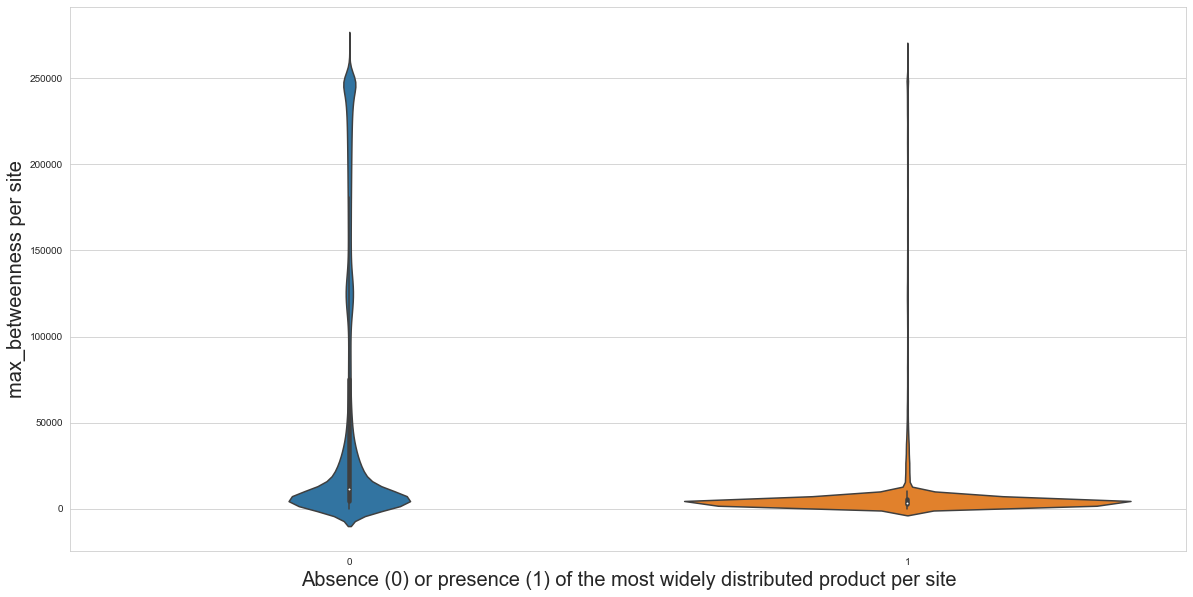

In [21]:
fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.violinplot(x = data_X, y = max_betweenness_Y) 
plt.xlabel('Absence (0) or presence (1) of the most widely distributed product per site', fontsize=20)
plt.ylabel('max_betweenness per site', fontsize=20)

### Max closeness and betweenness per production center vs width of that type

Here, the maximum closeness and betweenness centrality among traders on each production site is plotted against the distribution width of the corresponding tableware type.

Text(0, 0.5, 'max_closeness of production site')

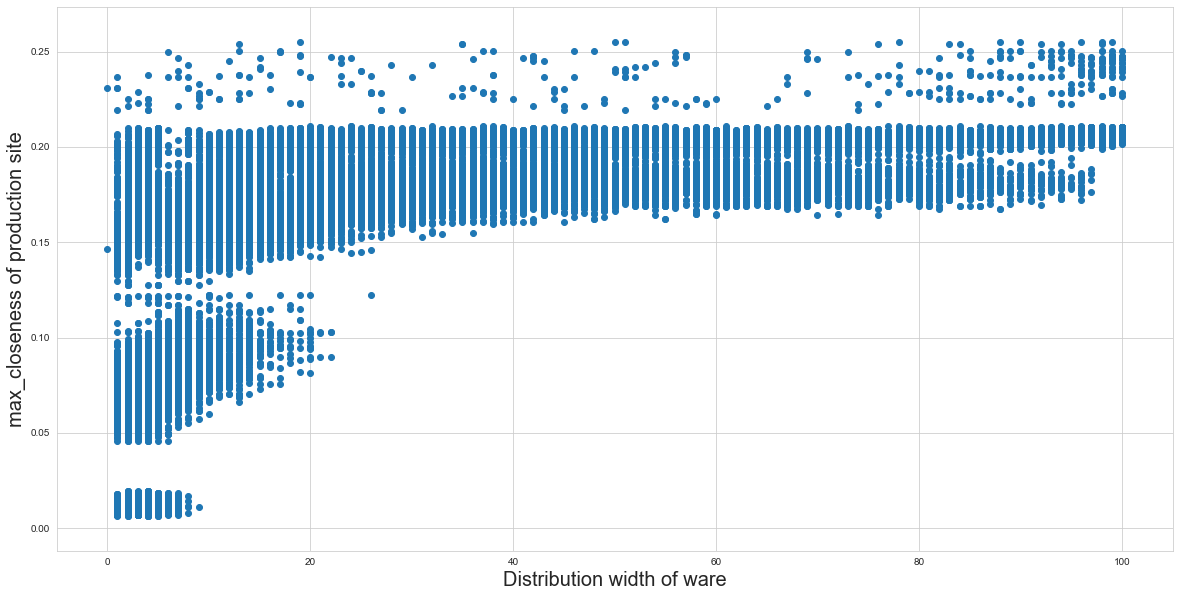

In [22]:
data_X = []
data_Y_closeness = []
data_Y_betweenness = []

for row, index in df.iterrows():
    widths = {'A': 0,
              'B': 0,
              'C': 0,
              'D': 0
             }
    site_dict = dict(index['site_dict'])
    
    for site_num, site_data in site_dict.items():
        if site_data[1] > 0:
            widths['A'] += 1
        if site_data[2] > 0:
            widths['B'] += 1
        if site_data[3] > 0:
            widths['C'] += 1
        if site_data[4] > 0:
            widths['D'] += 1
    
    widths = sorted(widths.items(), key=lambda x:x[1], reverse=True)
    width_num = 1    
    for i in widths:
        for site_num, site_data in site_dict.items():
            if site_data[0] == i[0]:
                closeness_list = []
                betweenness_list = []
                
                for cb in site_data[5]:
                    closeness_list.append(cb[0])
                    betweenness_list.append(cb[1])
                
                data_Y_closeness.append(max(closeness_list))
                data_Y_betweenness.append(max(betweenness_list))
                data_X.append(i[1])
                
                
fig, axes = plt.subplots(figsize = (20, 10))
ax = plt.scatter(data_X, data_Y_closeness) 
plt.xlabel('Distribution width of ware', fontsize=20)
plt.ylabel('max_closeness of production site', fontsize=20)

Text(0, 0.5, 'max_betweenness of production site')

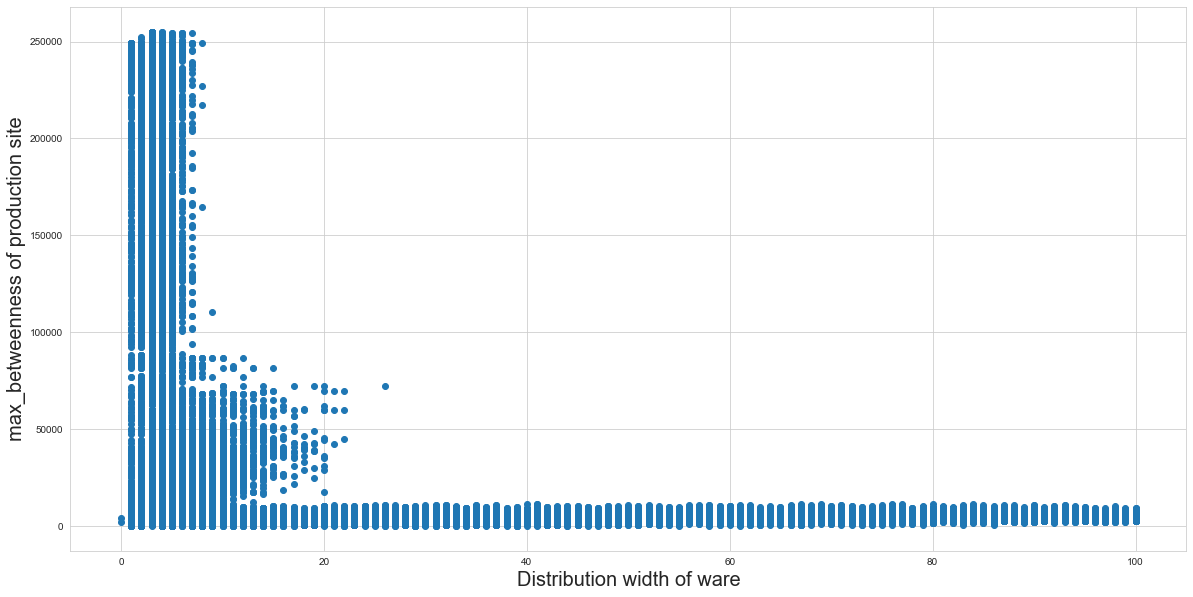

In [23]:
fig, axes = plt.subplots(figsize = (20, 10))
ax = plt.scatter(data_X, data_Y_betweenness) 
plt.xlabel('Distribution width of ware', fontsize=20)
plt.ylabel('max_betweenness of production site', fontsize=20)
                

### Line graphs of explanatory variables
'proportion_inter_site_links' and 'one_production_site_dominance' are singled out because the regression analysis has shown they are the most important in explaining the Ddiff.

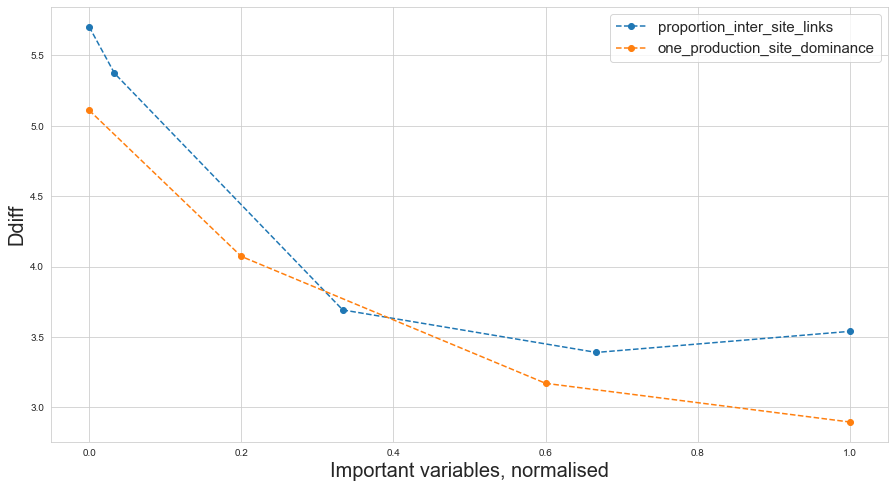

In [24]:
fig = plt.figure(figsize = (15, 8))
sns.set_style("whitegrid")

scaler=preprocessing.MinMaxScaler(feature_range=(0,1))

df_grp_inter = df.groupby(['proportion_inter_site_links']).mean().reset_index()
df_grp_inter['proportion_inter_site_links'] = scaler.fit_transform(df_grp_inter[['proportion_inter_site_links']])
df_grp_dom = df.groupby(['one_production_site_dominance']).mean().reset_index()
df_grp_dom['one_production_site_dominance'] = scaler.fit_transform(df_grp_dom[['one_production_site_dominance']])

plt.plot('proportion_inter_site_links', 'Ddiff',  data=df_grp_inter, linestyle='--', marker='o', label='proportion_inter_site_links')
plt.plot('one_production_site_dominance', 'Ddiff',  data=df_grp_dom, linestyle='--', marker='o', label='one_production_site_dominance')

plt.xlabel('Important variables, normalised', fontsize=20)
plt.ylabel('Ddiff', fontsize=20)
plt.legend(loc='best', fontsize=15)

### Hex plots of explanatory variables

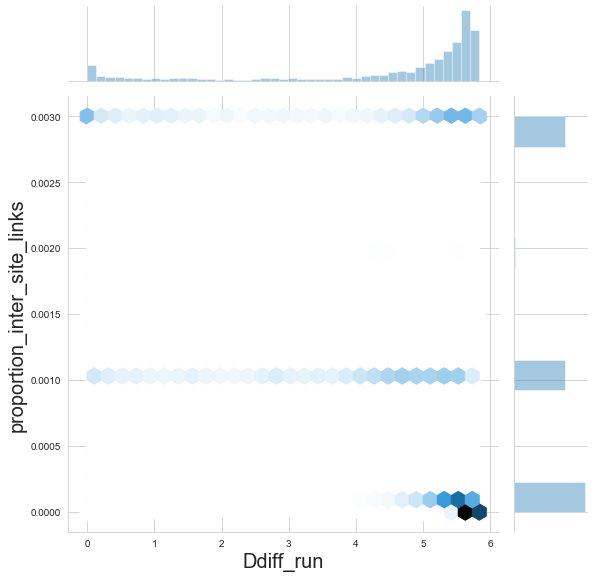

In [25]:
y = 'proportion_inter_site_links'

g = sns.jointplot(y=y, x='Ddiff', data=df, kind="hex", height=8)
g.set_axis_labels('Ddiff_run', y, fontsize=20)

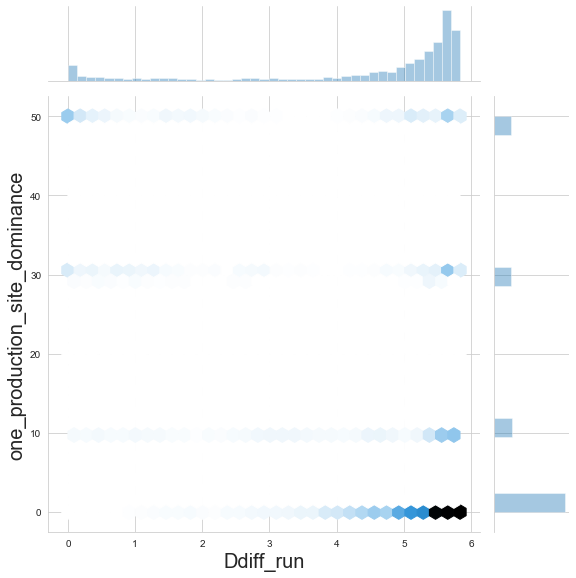

In [26]:
y = 'one_production_site_dominance'

g = sns.jointplot(y=y, x='Ddiff', data=df, kind="hex", height=8)
g.set_axis_labels('Ddiff_run', y, fontsize=20)